In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np
from scipy import fft
from scipy import signal
import sklearn as sk
from sklearn import preprocessing
#from ipynb.fs.full.ToolBox import connect_to_db

In [ ]:
# only with database access
engine = connect_to_db()

In [2]:
# Returns a dataframe of the longest modec (flight level) == cfl (cleared flight level) plateau, filters out null values
def isolate_plateau(ifpsid):
    df = pd.read_sql_query("""SELECT instant,tas,plateau_cfl,cflok FROM sbx1.<table> WHERE ifpsid = '{ii}'""".format(ii=ifpsid),engine)
    df = df[df.tas.notna() & df.cflok == 1]
    df = df.loc[df.plateau_cfl == df.groupby('plateau_cfl').instant.apply(np.ptp).idxmax()]
    return df

# Applies a median filter to tas (true air speed) and picks out every nth value
def medfilt(df,ks=5):
    return signal.medfilt(df.tas,kernel_size=ks)[2::ks]

# Scaler to apply zero-mean, unit-variance
def zm_uv(arr):
    scaler = preprocessing.StandardScaler().fit(arr.reshape(-1, 1))
    scaled = scaler.transform(arr.reshape(-1, 1))
    return scaled

# FFT
def dft(arr):
    n = len(arr)
    yf = fft.rfft(arr,n=n,axis=0)
    xf = fft.rfftfreq(n)
    return [xf[:],yf.flatten()[:]]

# interpolation
def interpol(arr,n):
    s = len(arr) / n
    steps = [s*x for x in range(n)]
    return np.array([arr[int(s)]+(arr[int(np.ceil(s))]-arr[int(s)])*(s-int(s)) for s in steps])

# min-max-scaler
def scale(arr):
    return np.array([2*x/(max(arr)+min(arr))-1 for x in arr])

In [ ]:
%%time
## construction of fft feature vector
# Note: Will not work without database access. Use df_fft_lip.pickle for further processing.
df_ifpsid = pd.read_pickle("../Notebooks/pickles/df_ifpsid_suitable.pickle")
d_list = []
for index, row in df_ifpsid.iterrows():
    df = pd.read_sql_query("""SELECT instant,tas,plateau_cfl,cflok FROM sbx1.<table> WHERE ifpsid = '{ii}'""".format(ii=row.ifpsid),engine)
    vector = abs(dft(interpol(scale(medfilt(isolate_plateau(row.ifpsid))),30))[1])
    d_data_f = {'f'+str(k): vector[k] for k in range(16)}
    d_data_i = {'ifpsid': row.ifpsid}
    d_list.append({**d_data_i, **d_data_f})
df_fft = pd.DataFrame.from_dict(d_list)
df_fft.to_pickle(path="../Notebooks/pickles/df_fft_lip.pickle")

In [3]:
# use without database access
df_fft = pd.read_pickle("../Pickles/df_fft_lip.pickle")

In [4]:
df_fft

,ifpsid,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15
0,AA15095873,0.053538,0.095115,0.071780,0.029882,0.094832,0.019349,0.052441,0.026874,0.022165,0.037213,0.012845,0.017204,0.044316,0.017118,0.019380,0.028738
1,AA15100861,0.034645,0.039775,0.028596,0.022479,0.005099,0.009401,0.007534,0.011073,0.025918,0.013872,0.018072,0.004954,0.012157,0.011399,0.008205,0.015873
2,AA15101625,0.049778,0.075753,0.031752,0.026490,0.028396,0.006222,0.016100,0.012038,0.014485,0.014871,0.008755,0.006346,0.004350,0.004765,0.006650,0.007111
3,AA15096981,0.100506,0.037988,0.096688,0.038139,0.037139,0.031443,0.034503,0.031903,0.035713,0.015301,0.014515,0.007032,0.001629,0.017301,0.013404,0.025307
4,AA15102824,0.035772,0.048944,0.011873,0.025293,0.016070,0.011577,0.017316,0.016404,0.014674,0.006540,0.010034,0.024395,0.009734,0.013673,0.008114,0.015718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181126,AA17164351,0.043860,0.036873,0.021007,0.005110,0.024609,0.014380,0.009064,0.014404,0.010309,0.002984,0.001912,0.006784,0.004863,0.012555,0.007421,0.007018
181127,AA17164443,0.066223,0.041314,0.062903,0.050537,0.009420,0.011078,0.002484,0.010271,0.010778,0.017432,0.008830,0.014404,0.009425,0.002224,0.002344,0.002661
181128,AA17164530,0.008728,0.049852,0.006638,0.012472,0.009734,0.021118,0.004620,0.014118,0.012033,0.012218,0.006219,0.020893,0.013698,0.011865,0.016546,0.009029
181129,AA17164555,0.016810,0.006947,0.009978,0.010447,0.004654,0.008190,0.008613,0.017763,0.003805,0.018910,0.001293,0.009812,0.008757,0.002270,0.018618,0.000431


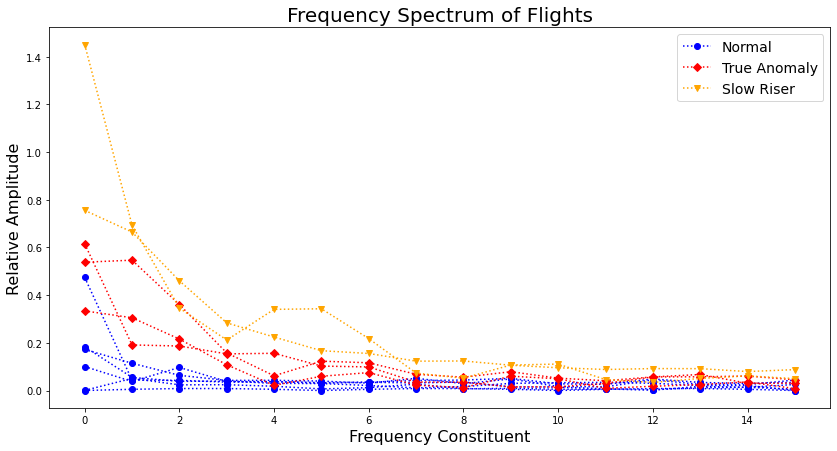

In [5]:
## Figure 2.5
plt.figure(figsize=(14,7))
plt.title('Frequency Spectrum of Flights',fontsize=20)
plt.xlabel('Frequency Constituent',fontsize=16)
plt.ylabel('Relative Amplitude',fontsize=16)
plt.plot((df_fft.query('ifpsid == "AA15095088"').iloc[:,1:].values.flatten()),ls=':',marker='o',c='blue')
plt.plot((df_fft.query('ifpsid == "AA15096981"').iloc[:,1:].values.flatten()),ls=':',marker='o',c='blue',label='_nolegend_')
plt.plot((df_fft.query('ifpsid == "AA15097026"').iloc[:,1:].values.flatten()),ls=':',marker='o',c='blue',label='_nolegend_')
plt.plot((df_fft.query('ifpsid == "AA15100284"').iloc[:,1:].values.flatten()),ls=':',marker='o',c='blue',label='_nolegend_')
plt.plot((df_fft.query('ifpsid == "AA15101959"').iloc[:,1:].values.flatten()),ls=':',marker='o',c='blue',label='_nolegend_')
plt.plot((df_fft.query('ifpsid == "AA15103929"').iloc[:,1:].values.flatten()),ls=':',marker='o',c='blue',label='_nolegend_')
plt.plot((df_fft.query('ifpsid == "AA15105533"').iloc[:,1:].values.flatten()),ls=':',marker='D',c='red')
plt.plot((df_fft.query('ifpsid == "AA15134176"').iloc[:,1:].values.flatten()),ls=':',marker='D',c='red',label='_nolegend_')
plt.plot((df_fft.query('ifpsid == "AA15127028"').iloc[:,1:].values.flatten()),ls=':',marker='D',c='red',label='_nolegend_')
plt.plot((df_fft.query('ifpsid == "AA15134240"').iloc[:,1:].values.flatten()),ls=':',marker='v',c='orange')
plt.plot((df_fft.query('ifpsid == "AA15100730"').iloc[:,1:].values.flatten()),ls=':',marker='v',c='orange',label='_nolegend_')
plt.legend(['Normal','True Anomaly','Slow Riser'],prop={'size': 14})